# So sánh APPA Algorithm: Thuật toán gốc vs LLM-based Phase 1

Notebook này so sánh hiệu suất giữa:
- **Thuật toán gốc**: Sử dụng Phase 1 dựa trên Effective Time Ratio (ETR)
- **Thuật toán LLM**: Sử dụng Gemini LLM để thực hiện Phase 1 (phân bổ vùng cho UAV)

Phase 2 (Order Optimization) giữ nguyên cho cả hai phương pháp.

## 1. Import Libraries và Setup

In [1]:
import os
import numpy as np
import time
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from utils.create_sample import create_sample
from utils.config import UAV, Region
from algorithm.appa import APPAAlgorithm
import json
import re
from typing import Dict, List
from langchain_openai import ChatOpenAI

# Load environment variables
load_dotenv()

# Get API key
llm=ChatOpenAI(model='gpt-5.1',temperature=0)

/Users/lebaminhphuc/anaconda3/envs/llms/lib/python3.11/site-packages/google/rpc/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
llm.invoke("xin chao")

AIMessage(content='Chào bạn!  \nMình có thể giúp gì cho bạn hôm nay?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 9, 'total_tokens': 34, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5.1-2025-11-13', 'system_fingerprint': None, 'id': 'chatcmpl-Ch4p5J5lso9SC9lENin9S0jzBggHv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--9b53661f-8b51-4c51-a0f7-09f6e195103e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 25, 'total_tokens': 34, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 2. Tạo LLM-based APPA Algorithm Class

In [3]:
class LLMAPPAAlgorithm(APPAAlgorithm):
    """
    APPA Algorithm với Phase 1 được thay thế bằng LLM (Gemini)
    Phase 2 (Order Optimization) giữ nguyên
    """
    
    def __init__(self, uavs_list, regions_list, V_matrix, llm, **kwargs):
        super().__init__(uavs_list, regions_list, V_matrix, **kwargs)
        self.llm = llm
    
    def region_allocation_phase(self) -> Dict[int, List[int]]:
        """
        Phase 1: Region Allocation using LLM
        Thay thế thuật toán ETR bằng LLM để phân bổ regions cho UAVs
        """
        # Chuẩn bị thông tin cho LLM
        uav_info = []
        for i, uav in enumerate(self.uavs_list):
            uav_info.append({
                "id": i,
                "max_velocity": float(uav.max_velocity),
                "scan_width": float(uav.scan_width)
            })
        
        region_info = []
        for i, region in enumerate(self.regions_list):
            region_info.append({
                "id": i,
                "coords": [float(region.coords[0]), float(region.coords[1])],
                "area": float(region.area)
            })
        
        # Tạo V_matrix info (khả năng quét)
        v_matrix_info = self.V_matrix.tolist()
        
        # Tạo prompt cho LLM
        prompt = f"""You are an expert in UAV task allocation optimization.

Given the following problem:
- Number of UAVs: {self.num_uavs}
- Number of regions to scan: {self.num_regions}
- Base location: (0, 0)

UAV Information:
{json.dumps(uav_info, indent=2)}

Region Information (coords and area):
{json.dumps(region_info, indent=2)}

Scan Velocity Matrix V[i][j] (UAV i's scan velocity at region j):
{json.dumps(v_matrix_info, indent=2)}

Formulas:
- Scan Time: TS[i,j] = Area[j] / (V[i,j] * ScanWidth[i])
- Flight Time: TF[i,j,k] = Distance(j,k) / MaxVelocity[i]
- Total Time for UAV i: Sum of all flight times + scan times for assigned regions

Task: Allocate ALL {self.num_regions} regions to {self.num_uavs} UAVs to minimize the maximum completion time among all UAVs.

IMPORTANT CONSTRAINTS:
1. Every region MUST be assigned to exactly ONE UAV
2. Each UAV can be assigned 0 or more regions
3. If V[i,j] = 0, UAV i CANNOT scan region j
4. Balance the workload among UAVs to minimize max completion time

Return ONLY a valid JSON object in this exact format (no markdown, no explanation):
{{
  "allocation": {{
    "0": [list of region IDs],
    "1": [list of region IDs],
    ...
  }}
}}

Example format:
{{"allocation": {{"0": [0, 3, 5], "1": [1, 2], "2": [4]}}}}"""

        # Gọi LLM
        try:
            response = self.llm.invoke(prompt)
            response_text = response.content.strip()
            
            # Parse JSON response
            # Remove markdown code blocks if present
            response_text = re.sub(r'```json\s*', '', response_text)
            response_text = re.sub(r'```\s*', '', response_text)
            
            result = json.loads(response_text)
            allocation = result["allocation"]
            
            # Convert string keys to int and validate
            region_assignment = {}
            assigned_regions = set()
            
            for uav_idx_str, regions in allocation.items():
                uav_idx = int(uav_idx_str)
                region_assignment[uav_idx] = regions
                assigned_regions.update(regions)
            
            # Validate all regions are assigned
            all_regions = set(range(self.num_regions))
            if assigned_regions != all_regions:
                print(f"⚠️  LLM didn't assign all regions. Using fallback method.")
                return self._fallback_allocation()
            
            # Validate V_matrix constraints
            for uav_idx, regions in region_assignment.items():
                for region_idx in regions:
                    if self.V_matrix[uav_idx][region_idx] == 0:
                        print(f"⚠️  Invalid assignment: UAV {uav_idx} cannot scan region {region_idx}")
                        return self._fallback_allocation()
            
            return region_assignment
            
        except Exception as e:
            print(f"⚠️  LLM allocation failed: {e}")
            print(f"Response: {response_text if 'response_text' in locals() else 'No response'}")
            return self._fallback_allocation()
    
    def _fallback_allocation(self) -> Dict[int, List[int]]:
        """Fallback to original ETR-based allocation if LLM fails"""
        print("Using original ETR-based allocation as fallback...")
        return super().region_allocation_phase()

print("✅ LLMAPPAAlgorithm class created!")

✅ LLMAPPAAlgorithm class created!


## 3. Tạo Sample Data

In [4]:
# Tạo sample data với kích thước nhỏ để test
NUM_UAVS = 3
NUM_REGIONS = 15
SYSTEM_AREA_RATIO = 0.05
SYSTEM_DRAG_FACTOR = 0.9

data = create_sample(NUM_UAVS, NUM_REGIONS, SYSTEM_AREA_RATIO, SYSTEM_DRAG_FACTOR)

# Convert to objects
uavs_list = [UAV(**uav_dict) for uav_dict in data['uavs_list']]
regions_list = [Region(**region) for region in data['regions_list']]
V_matrix = data['V_matrix']

print(f"✅ Sample data created:")
print(f"   - UAVs: {NUM_UAVS}")
print(f"   - Regions: {NUM_REGIONS}")
print(f"   - UAV properties: max_velocity, scan_width")
print(f"   - Region properties: coords, area")

✅ Sample data created:
   - UAVs: 3
   - Regions: 15
   - UAV properties: max_velocity, scan_width
   - Region properties: coords, area


## 4. Chạy thuật toán gốc (Original APPA)

In [5]:
print("=" * 60)
print("RUNNING ORIGINAL APPA ALGORITHM")
print("=" * 60)

# Initialize original APPA
original_appa = APPAAlgorithm(
    uavs_list=uavs_list,
    regions_list=regions_list,
    V_matrix=V_matrix,
    num_ants=20,
    max_iterations=50
)

# Run and measure time
start_time = time.time()
original_result = original_appa.solve()
original_time = time.time() - start_time

print(f"\n✅ Original APPA completed in {original_time:.2f} seconds")
print(f"\n📊 Results:")
print(f"   - Max Completion Time: {original_result['max_completion_time']:.2f}")
print(f"\n   - Region allocation per UAV:")
for uav_idx, path in original_result['paths'].items():
    print(f"     UAV {uav_idx}: {len(path)} regions, Time: {original_result['completion_times'][uav_idx]:.2f}")
    print(f"              Path: {path}")

RUNNING ORIGINAL APPA ALGORITHM

✅ Original APPA completed in 0.01 seconds

📊 Results:
   - Max Completion Time: 100.12

   - Region allocation per UAV:
     UAV 0: 3 regions, Time: 95.16
              Path: [14, 1, 12]
     UAV 1: 8 regions, Time: 82.21
              Path: [9, 2, 11, 0, 6, 13, 8, 4]
     UAV 2: 4 regions, Time: 100.12
              Path: [10, 3, 5, 7]


## 5. Chạy thuật toán LLM-based (LLM APPA)

In [15]:
print("\n" + "=" * 60)
print("RUNNING LLM-BASED APPA ALGORITHM")
print("=" * 60)

# Initialize LLM-based APPA
llm_appa = LLMAPPAAlgorithm(
    uavs_list=uavs_list,
    regions_list=regions_list,
    V_matrix=V_matrix,
    llm=llm,
    num_ants=20,
    max_iterations=50
)

# Run and measure time
start_time = time.time()
llm_result = llm_appa.solve()
llm_time = time.time() - start_time

print(f"\n✅ LLM APPA completed in {llm_time:.2f} seconds")
print(f"\n📊 Results:")
print(f"   - Max Completion Time: {llm_result['max_completion_time']:.2f}")
print(f"\n   - Region allocation per UAV:")
for uav_idx, path in llm_result['paths'].items():
    print(f"     UAV {uav_idx}: {len(path)} regions, Time: {llm_result['completion_times'][uav_idx]:.2f}")
    print(f"              Path: {path}")


RUNNING LLM-BASED APPA ALGORITHM

✅ LLM APPA completed in 1.78 seconds

📊 Results:
   - Max Completion Time: 98.84

   - Region allocation per UAV:
     UAV 0: 4 regions, Time: 85.36
              Path: [0, 11, 1, 7]
     UAV 1: 5 regions, Time: 84.70
              Path: [2, 6, 13, 8, 10]
     UAV 2: 6 regions, Time: 98.84
              Path: [12, 9, 14, 5, 4, 3]


## 6. So sánh kết quả

## 6.1. Comprehensive Metrics Comparison (Multiple Evaluation Metrics)


In [16]:
from utils.metrics import MetricsCalculator

print("\n" + "=" * 70)
print("COMPREHENSIVE METRICS COMPARISON")
print("=" * 70)

# Initialize metrics calculator
metrics_calc = MetricsCalculator(uavs_list, regions_list, V_matrix)

# Calculate metrics for both methods
original_metrics = metrics_calc.calculate_all_metrics(original_result, original_time)
llm_metrics = metrics_calc.calculate_all_metrics(llm_result, llm_time)

# Compare metrics
comparison = metrics_calc.compare_metrics(
    original_metrics, 
    llm_metrics, 
    name1="Original APPA", 
    name2="LLM-based APPA"
)

# Create comprehensive comparison table
print("\n📊 Comprehensive Metrics Comparison Table:")
print("=" * 70)

# Group metrics by category
time_metrics = {
    'Max Completion Time': 'max_completion_time',
    'Avg Completion Time': 'avg_completion_time',
    'Min Completion Time': 'min_completion_time',
    'Execution Time (s)': 'execution_time'
}

workload_metrics = {
    'Workload Variance': 'workload_variance',
    'Workload Std Dev': 'workload_std',
    'Workload Balance Index': 'workload_balance_index'
}

distance_metrics = {
    'Total Distance': 'total_distance',
    'Avg Distance per UAV': 'avg_distance_per_uav'
}

efficiency_metrics = {
    'Total Scan Time': 'total_scan_time',
    'Total Flight Time': 'total_flight_time',
    'Efficiency Ratio': 'efficiency_ratio'
}

allocation_metrics = {
    'Allocation Balance': 'allocation_balance',
    'Avg UAV Utilization': 'avg_uav_utilization'
}

# Create tables for each category
def print_metric_table(title, metric_dict):
    print(f"\n{title}:")
    print("-" * 70)
    print(f"{'Metric':<30} {'Original APPA':<20} {'LLM APPA':<20} {'Improvement':<15}")
    print("-" * 70)
    
    for display_name, metric_key in metric_dict.items():
        if metric_key in comparison:
            comp = comparison[metric_key]
            orig_val = comp['Original APPA']
            llm_val = comp['LLM-based APPA']
            improvement = comp['improvement_pct']
            
            # Format values based on type
            if isinstance(orig_val, float):
                if abs(orig_val) < 0.01:
                    orig_str = f"{orig_val:.5f}"
                elif abs(orig_val) < 1:
                    orig_str = f"{orig_val:.3f}"
                else:
                    orig_str = f"{orig_val:.2f}"
                
                if abs(llm_val) < 0.01:
                    llm_str = f"{llm_val:.5f}"
                elif abs(llm_val) < 1:
                    llm_str = f"{llm_val:.3f}"
                else:
                    llm_str = f"{llm_val:.2f}"
            else:
                orig_str = str(orig_val)
                llm_str = str(llm_val)
            
            # Format improvement
            if abs(improvement) < 0.01:
                imp_str = f"{improvement:.3f}%"
            else:
                imp_str = f"{improvement:+.2f}%"
            
            better = "✅" if comp['better'] == 'LLM-based APPA' else "⚠️"
            print(f"{display_name:<30} {orig_str:<20} {llm_str:<20} {imp_str:<14} {better}")

print_metric_table("⏱️  TIME METRICS", time_metrics)
print_metric_table("⚖️  WORKLOAD BALANCE METRICS", workload_metrics)
print_metric_table("📏 DISTANCE METRICS", distance_metrics)
print_metric_table("⚡ EFFICIENCY METRICS", efficiency_metrics)
print_metric_table("📊 ALLOCATION METRICS", allocation_metrics)

# Calculate deviation ratio (comparing to original as baseline)
deviation_ratio = metrics_calc.calculate_deviation_ratio(
    llm_metrics['max_completion_time'],
    original_metrics['max_completion_time']
)

print("\n" + "=" * 70)
print("📈 KEY PERFORMANCE INDICATORS")
print("=" * 70)
print(f"Deviation Ratio (vs Original): {deviation_ratio:+.2f}%")
print(f"  - Positive = LLM solution is worse")
print(f"  - Negative = LLM solution is better")
print(f"\nWorkload Balance Improvement: {comparison['workload_balance_index']['improvement_pct']:+.2f}%")
print(f"  - Lower is better (more balanced workload)")
print(f"\nEfficiency Ratio Improvement: {comparison['efficiency_ratio']['improvement_pct']:+.2f}%")
print(f"  - Higher is better (more time scanning vs flying)")

print("\n" + "=" * 70)



COMPREHENSIVE METRICS COMPARISON

📊 Comprehensive Metrics Comparison Table:

⏱️  TIME METRICS:
----------------------------------------------------------------------
Metric                         Original APPA        LLM APPA             Improvement    
----------------------------------------------------------------------
Max Completion Time            100.12               98.84                +1.28%         ✅
Avg Completion Time            92.50                89.63                -3.10%         ⚠️
Execution Time (s)             0.00834              1.78                 -21229.93%     ⚠️

⚖️  WORKLOAD BALANCE METRICS:
----------------------------------------------------------------------
Metric                         Original APPA        LLM APPA             Improvement    
----------------------------------------------------------------------
Workload Variance              56.98                42.47                +25.46%        ✅
Workload Std Dev               7.55              

## 6.2. Visualization of Multiple Metrics


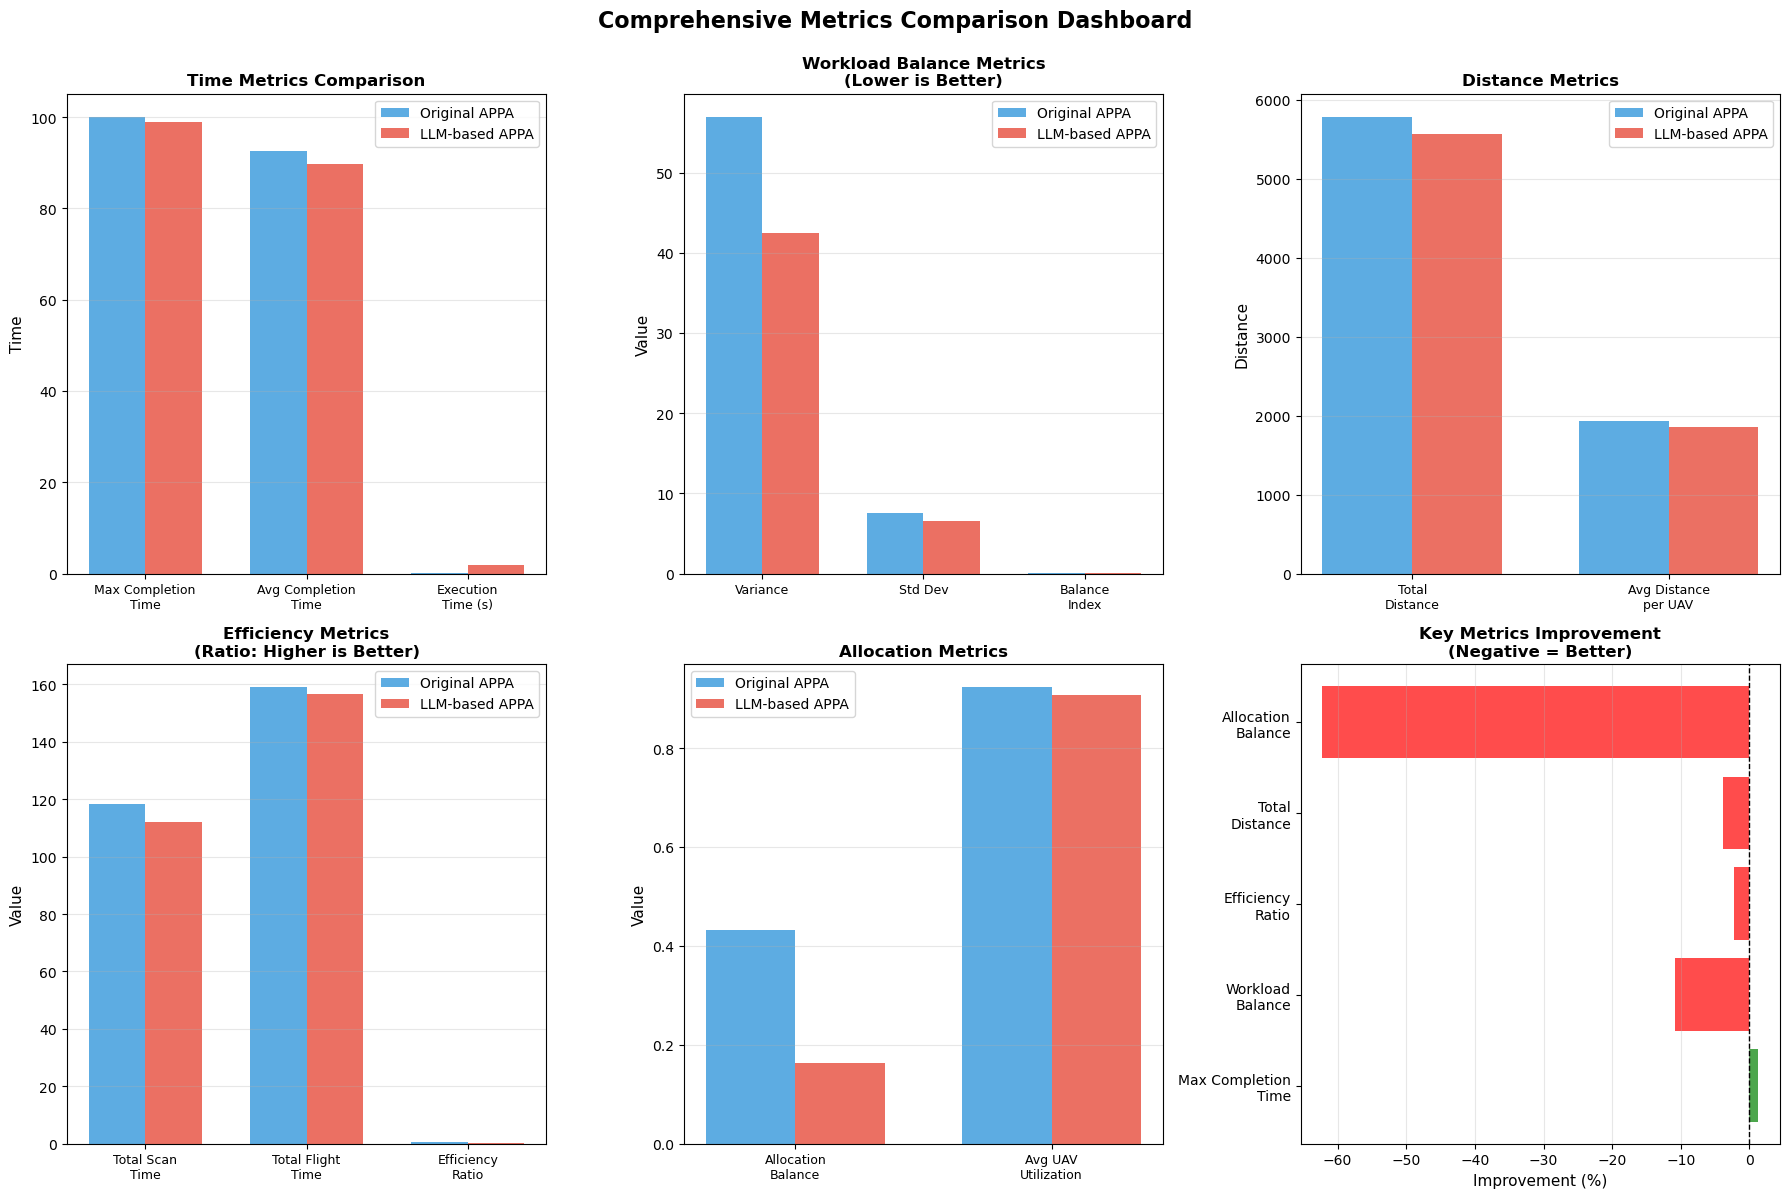

✅ Comprehensive metrics dashboard saved to ./fig/comprehensive_metrics_dashboard.png


In [17]:

# Create comprehensive visualization dashboard
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Metrics Comparison Dashboard', fontsize=16, fontweight='bold', y=0.995)

# 1. Time Metrics Comparison
ax1 = axes[0, 0]
time_metric_names = ['Max Completion\nTime', 'Avg Completion\nTime', 'Execution\nTime (s)']
time_original = [
    original_metrics['max_completion_time'],
    original_metrics['avg_completion_time'],
    original_metrics['execution_time']
]
time_llm = [
    llm_metrics['max_completion_time'],
    llm_metrics['avg_completion_time'],
    llm_metrics['execution_time']
]
x = np.arange(len(time_metric_names))
width = 0.35
ax1.bar(x - width/2, time_original, width, label='Original APPA', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, time_llm, width, label='LLM-based APPA', color='#e74c3c', alpha=0.8)
ax1.set_ylabel('Time', fontsize=11)
ax1.set_title('Time Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(time_metric_names, fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Workload Balance Metrics
ax2 = axes[0, 1]
workload_metric_names = ['Variance', 'Std Dev', 'Balance\nIndex']
workload_original = [
    original_metrics['workload_variance'],
    original_metrics['workload_std'],
    original_metrics['workload_balance_index']
]
workload_llm = [
    llm_metrics['workload_variance'],
    llm_metrics['workload_std'],
    llm_metrics['workload_balance_index']
]
x = np.arange(len(workload_metric_names))
ax2.bar(x - width/2, workload_original, width, label='Original APPA', color='#3498db', alpha=0.8)
ax2.bar(x + width/2, workload_llm, width, label='LLM-based APPA', color='#e74c3c', alpha=0.8)
ax2.set_ylabel('Value', fontsize=11)
ax2.set_title('Workload Balance Metrics\n(Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(workload_metric_names, fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Distance Metrics
ax3 = axes[0, 2]
distance_metric_names = ['Total\nDistance', 'Avg Distance\nper UAV']
distance_original = [
    original_metrics['total_distance'],
    original_metrics['avg_distance_per_uav']
]
distance_llm = [
    llm_metrics['total_distance'],
    llm_metrics['avg_distance_per_uav']
]
x = np.arange(len(distance_metric_names))
ax3.bar(x - width/2, distance_original, width, label='Original APPA', color='#3498db', alpha=0.8)
ax3.bar(x + width/2, distance_llm, width, label='LLM-based APPA', color='#e74c3c', alpha=0.8)
ax3.set_ylabel('Distance', fontsize=11)
ax3.set_title('Distance Metrics', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(distance_metric_names, fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Efficiency Metrics
ax4 = axes[1, 0]
efficiency_metric_names = ['Total Scan\nTime', 'Total Flight\nTime', 'Efficiency\nRatio']
efficiency_original = [
    original_metrics['total_scan_time'],
    original_metrics['total_flight_time'],
    original_metrics['efficiency_ratio']
]
efficiency_llm = [
    llm_metrics['total_scan_time'],
    llm_metrics['total_flight_time'],
    llm_metrics['efficiency_ratio']
]
x = np.arange(len(efficiency_metric_names))
ax4.bar(x - width/2, efficiency_original, width, label='Original APPA', color='#3498db', alpha=0.8)
ax4.bar(x + width/2, efficiency_llm, width, label='LLM-based APPA', color='#e74c3c', alpha=0.8)
ax4.set_ylabel('Value', fontsize=11)
ax4.set_title('Efficiency Metrics\n(Ratio: Higher is Better)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(efficiency_metric_names, fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Allocation Balance
ax5 = axes[1, 1]
allocation_metric_names = ['Allocation\nBalance', 'Avg UAV\nUtilization']
allocation_original = [
    original_metrics['allocation_balance'],
    original_metrics['avg_uav_utilization']
]
allocation_llm = [
    llm_metrics['allocation_balance'],
    llm_metrics['avg_uav_utilization']
]
x = np.arange(len(allocation_metric_names))
ax5.bar(x - width/2, allocation_original, width, label='Original APPA', color='#3498db', alpha=0.8)
ax5.bar(x + width/2, allocation_llm, width, label='LLM-based APPA', color='#e74c3c', alpha=0.8)
ax5.set_ylabel('Value', fontsize=11)
ax5.set_title('Allocation Metrics', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(allocation_metric_names, fontsize=9)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Improvement Summary (Radar/Bar chart)
ax6 = axes[1, 2]
# Select key metrics for improvement summary
key_metrics = {
    'Max Completion\nTime': comparison['max_completion_time']['improvement_pct'],
    'Workload\nBalance': -comparison['workload_balance_index']['improvement_pct'],  # Negative because lower is better
    'Efficiency\nRatio': comparison['efficiency_ratio']['improvement_pct'],
    'Total\nDistance': -comparison['total_distance']['improvement_pct'],  # Negative because lower is better
    'Allocation\nBalance': -comparison['allocation_balance']['improvement_pct']  # Negative because lower is better
}
metric_names = list(key_metrics.keys())
improvements = list(key_metrics.values())
colors = ['green' if x > 0 else 'red' for x in improvements]
ax6.barh(metric_names, improvements, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Improvement (%)', fontsize=11)
ax6.set_title('Key Metrics Improvement\n(Negative = Better)', fontsize=12, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('./fig/comprehensive_metrics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive metrics dashboard saved to ./fig/comprehensive_metrics_dashboard.png")


## 6.3. Academic Table for Paper


In [ ]:
# Create academic-style comparison table for paper
from main import create_table_image

# Prepare data for the table
table_headers = ['Metric', 'Original APPA', 'LLM-based APPA', 'Deviation Ratio (%)']

table_data = [
    # Time metrics
    ['Max Completion Time', 
     f"{original_metrics['max_completion_time']:.2f}", 
     f"{llm_metrics['max_completion_time']:.2f}",
     f"{deviation_ratio:.2f}"],
    
    ['Avg Completion Time', 
     f"{original_metrics['avg_completion_time']:.2f}", 
     f"{llm_metrics['avg_completion_time']:.2f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['avg_completion_time'], original_metrics['avg_completion_time']):.2f}"],
    
    ['Execution Time (s)', 
     f"{original_metrics['execution_time']:.4f}", 
     f"{llm_metrics['execution_time']:.4f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['execution_time'], original_metrics['execution_time']):.2f}"],
    
    # Workload balance
    ['Workload Variance', 
     f"{original_metrics['workload_variance']:.2f}", 
     f"{llm_metrics['workload_variance']:.2f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['workload_variance'], original_metrics['workload_variance']):.2f}"],
    
    ['Workload Balance Index', 
     f"{original_metrics['workload_balance_index']:.4f}", 
     f"{llm_metrics['workload_balance_index']:.4f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['workload_balance_index'], original_metrics['workload_balance_index']):.2f}"],
    
    # Distance metrics
    ['Total Distance', 
     f"{original_metrics['total_distance']:.2f}", 
     f"{llm_metrics['total_distance']:.2f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['total_distance'], original_metrics['total_distance']):.2f}"],
    
    # Efficiency metrics
    ['Efficiency Ratio', 
     f"{original_metrics['efficiency_ratio']:.4f}", 
     f"{llm_metrics['efficiency_ratio']:.4f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['efficiency_ratio'], original_metrics['efficiency_ratio']):.2f}"],
    
    # Allocation metrics
    ['Allocation Balance', 
     f"{original_metrics['allocation_balance']:.4f}", 
     f"{llm_metrics['allocation_balance']:.4f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['allocation_balance'], original_metrics['allocation_balance']):.2f}"],
    
    ['Avg UAV Utilization', 
     f"{original_metrics['avg_uav_utilization']:.4f}", 
     f"{llm_metrics['avg_uav_utilization']:.4f}",
     f"{metrics_calc.calculate_deviation_ratio(llm_metrics['avg_uav_utilization'], original_metrics['avg_uav_utilization']):.2f}"],
]

# Create and save table image
create_table_image(
    headers=table_headers,
    data=table_data,
    filename='./fig/comprehensive_comparison_table.png',
    figsize=(14, 6)
)

print("✅ Academic comparison table saved to ./fig/comprehensive_comparison_table.png")
print("\n📋 Table includes:")
print("   - Time metrics (completion time, execution time)")
print("   - Workload balance metrics (variance, balance index)")
print("   - Distance metrics (total distance)")
print("   - Efficiency metrics (efficiency ratio)")
print("   - Allocation metrics (balance, utilization)")
print("   - Deviation ratio for each metric")


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)

# Create comparison table
comparison_data = {
    'Metric': [
        'Max Completion Time (Task Time)',
        'Execution Time (Code Runtime)',
        'Improvement in Task Time (%)',
        'Trade-off in Code Runtime'
    ],
    'Original APPA': [
        f"{original_result['max_completion_time']:.2f}",
        f"{original_time:.2f}s",
        '-',
        '-'
    ],
    'LLM-based APPA': [
        f"{llm_result['max_completion_time']:.2f}",
        f"{llm_time:.2f}s",
        f"{((original_result['max_completion_time'] - llm_result['max_completion_time']) / original_result['max_completion_time'] * 100):.2f}%",
        f"{((llm_time - original_time) / original_time * 100):+.2f}%"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Comparison Table:")
print(df_comparison.to_string(index=False))

# Calculate improvements
task_improvement = ((original_result['max_completion_time'] - llm_result['max_completion_time']) / 
                    original_result['max_completion_time'] * 100)
runtime_overhead = ((llm_time - original_time) / original_time * 100)

print(f"\n🎯 Key Insights:")
print(f"   - Task Completion Time Improvement: {task_improvement:.2f}%")
print(f"   - Code Runtime Overhead: {runtime_overhead:+.2f}%")

if task_improvement > 0:
    print(f"   ✅ LLM approach produces BETTER task completion time!")
elif task_improvement < 0:
    print(f"   ⚠️  LLM approach produces WORSE task completion time")
else:
    print(f"   ➡️  Both approaches have SAME task completion time")

print(f"\n💡 Note: 'Task Time' is the time UAVs need to complete all regions (optimization goal)")
print(f"         'Code Runtime' is the time to run the algorithm (computational cost)")


COMPARISON RESULTS

📊 Comparison Table:
                         Metric Original APPA LLM-based APPA
Max Completion Time (Task Time)        100.12          92.46
  Execution Time (Code Runtime)         0.02s          2.80s
   Improvement in Task Time (%)             -          7.65%
      Trade-off in Code Runtime             -     +16337.72%

🎯 Key Insights:
   - Task Completion Time Improvement: 7.65%
   - Code Runtime Overhead: +16337.72%
   ✅ LLM approach produces BETTER task completion time!

💡 Note: 'Task Time' is the time UAVs need to complete all regions (optimization goal)
         'Code Runtime' is the time to run the algorithm (computational cost)


## 7. Visualization - So sánh thời gian

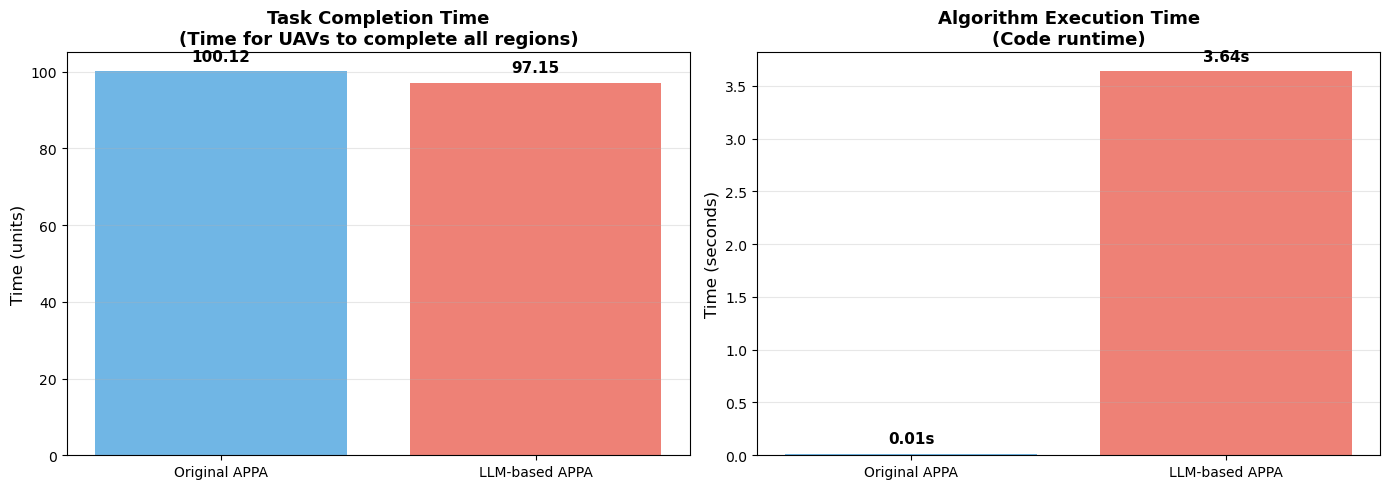

✅ Chart saved to ./fig/comparison_chart.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Task Completion Time (Max Completion Time)
algorithms = ['Original APPA', 'LLM-based APPA']
task_times = [original_result['max_completion_time'], llm_result['max_completion_time']]

axes[0].bar(algorithms, task_times, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Time (units)', fontsize=12)
axes[0].set_title('Task Completion Time\n(Time for UAVs to complete all regions)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task_times):
    axes[0].text(i, v + max(task_times) * 0.02, f'{v:.2f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Code Execution Time (Runtime)
runtime_times = [original_time, llm_time]

axes[1].bar(algorithms, runtime_times, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Algorithm Execution Time\n(Code runtime)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(runtime_times):
    axes[1].text(i, v + max(runtime_times) * 0.02, f'{v:.2f}s', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('./fig/comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart saved to ./fig/comparison_chart.png")

## 8. Detailed UAV Workload Comparison

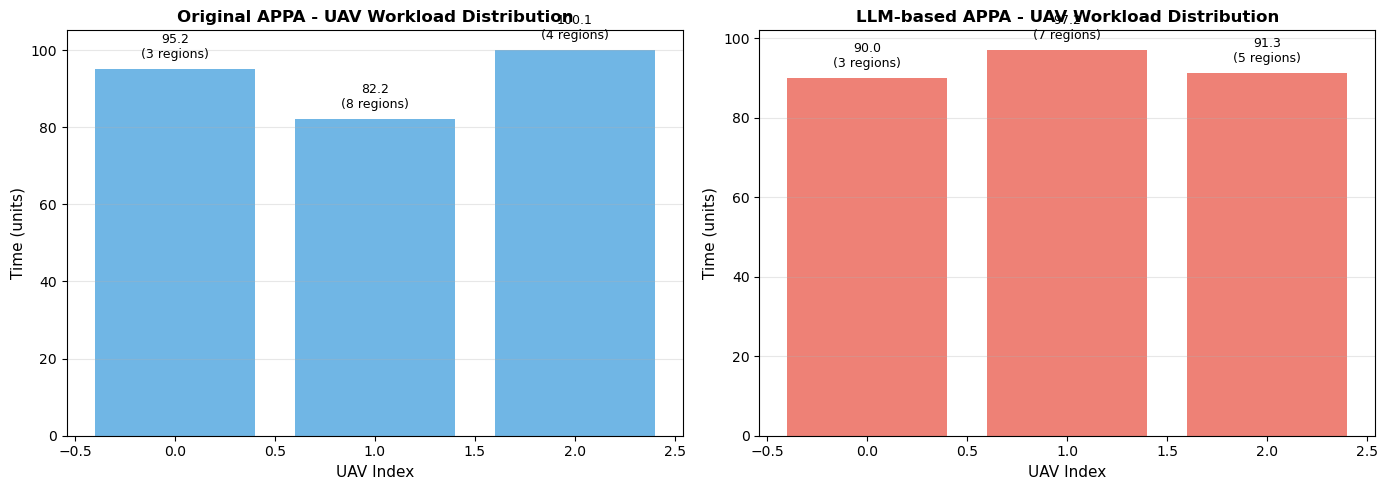

✅ Workload comparison chart saved to ./fig/workload_comparison.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original APPA workload distribution
uav_indices_original = list(original_result['completion_times'].keys())
completion_times_original = [original_result['completion_times'][i] for i in uav_indices_original]
region_counts_original = [len(original_result['paths'][i]) for i in uav_indices_original]

axes[0].bar(uav_indices_original, completion_times_original, color='#3498db', alpha=0.7, label='Completion Time')
axes[0].set_xlabel('UAV Index', fontsize=11)
axes[0].set_ylabel('Time (units)', fontsize=11)
axes[0].set_title('Original APPA - UAV Workload Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add region count labels
for i, (ct, rc) in enumerate(zip(completion_times_original, region_counts_original)):
    axes[0].text(i, ct + max(completion_times_original) * 0.02, 
                f'{ct:.1f}\n({rc} regions)', 
                ha='center', va='bottom', fontsize=9)

# LLM APPA workload distribution
uav_indices_llm = list(llm_result['completion_times'].keys())
completion_times_llm = [llm_result['completion_times'][i] for i in uav_indices_llm]
region_counts_llm = [len(llm_result['paths'][i]) for i in uav_indices_llm]

axes[1].bar(uav_indices_llm, completion_times_llm, color='#e74c3c', alpha=0.7, label='Completion Time')
axes[1].set_xlabel('UAV Index', fontsize=11)
axes[1].set_ylabel('Time (units)', fontsize=11)
axes[1].set_title('LLM-based APPA - UAV Workload Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add region count labels
for i, (ct, rc) in enumerate(zip(completion_times_llm, region_counts_llm)):
    axes[1].text(i, ct + max(completion_times_llm) * 0.02, 
                f'{ct:.1f}\n({rc} regions)', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./fig/workload_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Workload comparison chart saved to ./fig/workload_comparison.png")

## 9. Summary & Conclusion

In [17]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
🔍 Experiment Configuration:
   - Number of UAVs: {NUM_UAVS}
   - Number of Regions: {NUM_REGIONS}
   - LLM Model: Gemini-1.5-Flash

📊 Results Comparison:

   Algorithm Type          | Task Time | Code Runtime | Region Distribution
   ----------------------- | --------- | ------------ | -------------------
   Original APPA (ETR)     | {original_result['max_completion_time']:8.2f}  | {original_time:7.2f}s     | {region_counts_original}
   LLM-based APPA (Gemini) | {llm_result['max_completion_time']:8.2f}  | {llm_time:7.2f}s     | {region_counts_llm}

🎯 Performance Metrics:
   - Task Completion Time Difference: {task_improvement:+.2f}%
   - Algorithm Runtime Overhead: {runtime_overhead:+.2f}%

💡 Key Findings:
   1. Task Time (Max Completion Time): 
      {"✅ LLM approach achieved BETTER optimization!" if task_improvement > 0 else "⚠️ Original approach is better" if task_improvement < 0 else "➡️ Both approaches achieved same result"}
   
   2. Code Runtime:
      {"⏱️  LLM approach takes more time to execute due to API calls" if runtime_overhead > 0 else "⚡ LLM approach is faster"}
   
   3. Trade-off:
      - LLM may provide better global optimization through its reasoning
      - But requires additional computational time for LLM inference
      - Original ETR algorithm is deterministic and faster

🔬 Interpretation:
   - "Task Time" is what matters for real-world UAV deployment
   - "Code Runtime" is the planning/computation overhead
   - LLM shows potential for improving optimization quality
""")

print("="*70)
print("Experiment completed successfully! ✅")
print("="*70)


FINAL SUMMARY


NameError: name 'task_improvement' is not defined